### Imports

In [9]:
from matplotlib import pyplot as plt
from data import load_data, load_narx_data
from matplotlib import pyplot as plt
import numpy as np
import torch
from data import load_narx_data
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, Matern, Product

In [10]:
n_a, n_b = 2, 2
Split = [0.6, 0.2, 0.2] # split; [training, validation, test]
total_number_of_points = 80000 # total number of points to consider from the larger dataset (starting from index 0)

In [11]:
Xtrain,Ytrain = load_narx_data(n_a, n_b, total_number_of_points, section="train", split=Split, as_tensor=True)
Xval,Yval = load_narx_data(n_a, n_b, total_number_of_points, section="validation", split=Split, as_tensor=True)
Xtest,Ytest = load_narx_data(n_a, n_b, total_number_of_points, section="test", split=Split, as_tensor=True)

Considering 6000 datapoints
Using 3600 datapoints for training set
Considering 6000 datapoints
Using 1200 datapoints for validation set
Considering 6000 datapoints
Using 1200 datapoints for test set


In [12]:
# Standard settings
kernel = RBF(length_scale=1) + WhiteKernel(noise_level=0.1)
reg = GaussianProcessRegressor(kernel, n_restarts_optimizer=2)

In [13]:
# Create individual kernels
# rbf_kernel = RBF(length_scale=1.0)
# matern_kernel = Matern(length_scale=1.0, nu=1.5)
# white_kernel = WhiteKernel(noise_level=0.1)

# Combine kernels using the Product kernel
# combined_kernel = Product(rbf_kernel, matern_kernel, white_kernel)
# combined_kernel = Product(rbf_kernel, matern_kernel)
# reg = GaussianProcessRegressor(kernel=combined_kernel, n_restarts_optimizer=10)

In [14]:
# import GPy

# # Create a kernel
# kernel = GPy.kern.RBF(input_dim=Xtrain.shape[1], variance=1., lengthscale=1.) + GPy.kern.White(input_dim=Xtrain.shape[1], variance=0.1)

# # Create a sparse GP model
# reg = GPy.models.SparseGPRegression(Xtrain, Ytrain, kernel=kernel, num_inducing=100)

# # Fit the model
# reg.optimize(messages=True)

# # Make predictions
# Ytrain_pred, Ytrain_pred_var = reg.predict(Xtrain)
# Ytrain_pred_std = np.sqrt(Ytrain_pred_var)


Fit the GP

In [15]:
from scipy.sparse import csr_matrix

sparseTrain = csr_matrix(Xtrain)

In [16]:

reg.fit(sparseTrain.toarray(), Ytrain)

GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=0.1),
                         n_restarts_optimizer=2)

Make some nice plots

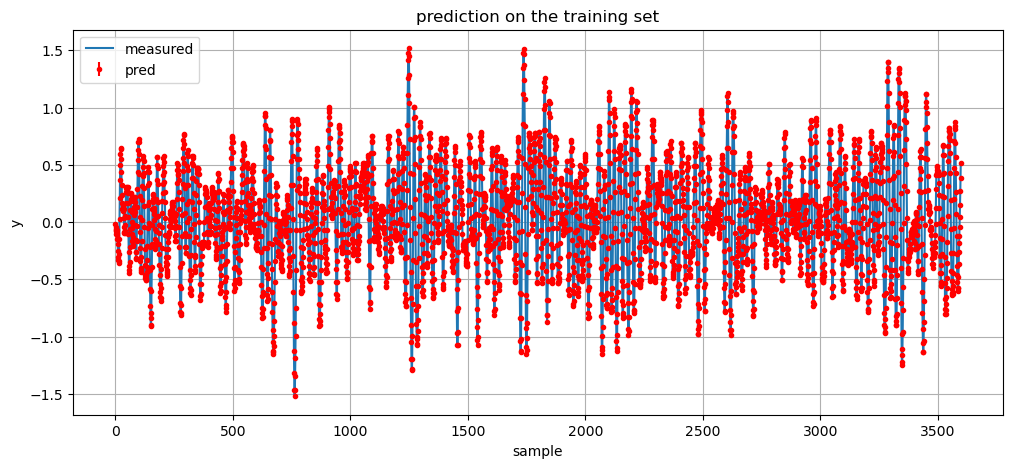

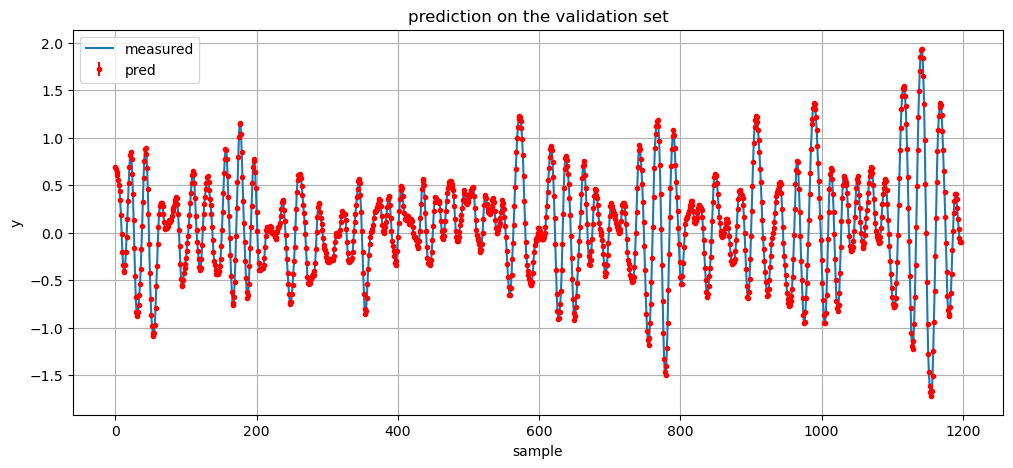

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [21]:
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True) 
plt.figure(figsize=(12,5)) 
plt.plot(Ytrain) 
plt.title('prediction on the training set')
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True) 
plt.errorbar(np.arange(len(Xtrain)), (Ytrain_pred), yerr=2*Ytrain_pred_std,fmt='.r') 
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred'])
# plt.xlim([500, 1000])
plt.show() 

# print(f'Training NRMS= {np.mean((Ytrain_pred - Ytrain) ** 2, axis=0) ** 0.5 / np.std(Ytrain)}')

plt.figure(figsize=(12,5)) 
plt.title('prediction on the validation set')
plt.plot(Yval) 
Yval_pred, Yval_pred_std = reg.predict(Xval,return_std=True) 
plt.errorbar(np.arange(len(Xval)), (Yval_pred), yerr=2*Yval_pred_std,fmt='.r') 
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred']) 
# plt.xlim([500, 1000])
plt.show() 

Yval = Yval.numpy()  # Convert Yval to a NumPy array

print(f'Validation NRMS= {np.mean((Yval_pred - Yval) ** 2, axis=0) ** 0.5 / np.std(Yval)}')


Resulting kernel hyperparameters: RBF(length_scale=4.23) + WhiteKernel(noise_level=2.04e-05)


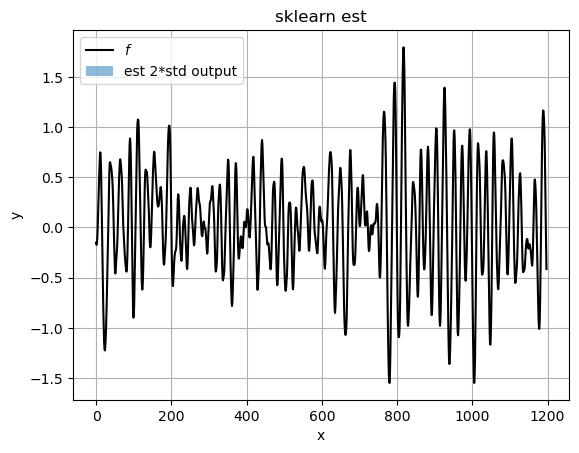

In [18]:
print('Resulting kernel hyperparameters:',reg.kernel_) #print optimized kernel
sigma_e = np.exp(reg.kernel_.k2.theta)**0.5 #extract the noise
#use regressor
ytest_p, ytest_std = reg.predict(Xtest,return_std=True) #a=)
ytest_std_mean = (ytest_std**2 - sigma_e**2)**0.5 #remove sigma_e noise to get mean deviation

#plot result
plt.plot(Ytest,'k',label='$f$')
# plt.plot(ytest_p,label='est mean')
# plt.xlim(min(Xtest),max(Xtest))
# plt.xlim(500,1000)
plt.fill_between(ytest_p-2*ytest_std_mean,ytest_p+2*ytest_std_mean,alpha=0.5,label='est 2*std output')
plt.grid(); plt.legend(); plt.xlabel('x'); plt.ylabel('y'); plt.title('sklearn est')
plt.show()

Resulting kernel hyperparameters: RBF(length_scale=4.23) + WhiteKernel(noise_level=2.04e-05)


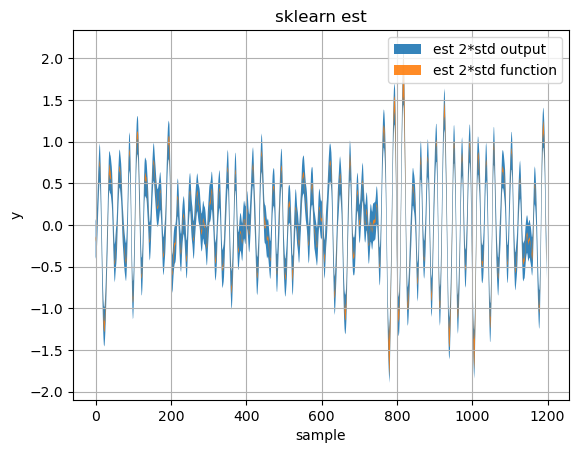

In [19]:
print('Resulting kernel hyperparameters:', reg.kernel_)  # print optimized kernel
sigma_e = np.exp(reg.kernel_.k2.theta) ** 0.5  # extract the noise

# Use regressor
ytest_p, ytest_std = reg.predict(Xtest, return_std=True)  # a)
ytest_std_mean = (ytest_std ** 2 - sigma_e ** 2) ** 0.5  # remove sigma_e noise to get mean deviation

# Plot result
# plt.plot(Ytest, 'k', label='$f$')
# plt.plot(ytest_p, label='est mean')
plt.fill_between(np.arange(len(Xtest)), ytest_p - 50 * ytest_std, ytest_p + 50 * ytest_std, alpha=0.9, label='est 2*std output')
plt.fill_between(np.arange(len(Xtest)), ytest_p - 50 * ytest_std_mean, ytest_p + 50 * ytest_std_mean, alpha=0.9, label='est 2*std function')
plt.grid()
plt.legend()
plt.xlabel('sample')
plt.ylabel('y')
plt.title('sklearn est')
plt.show()


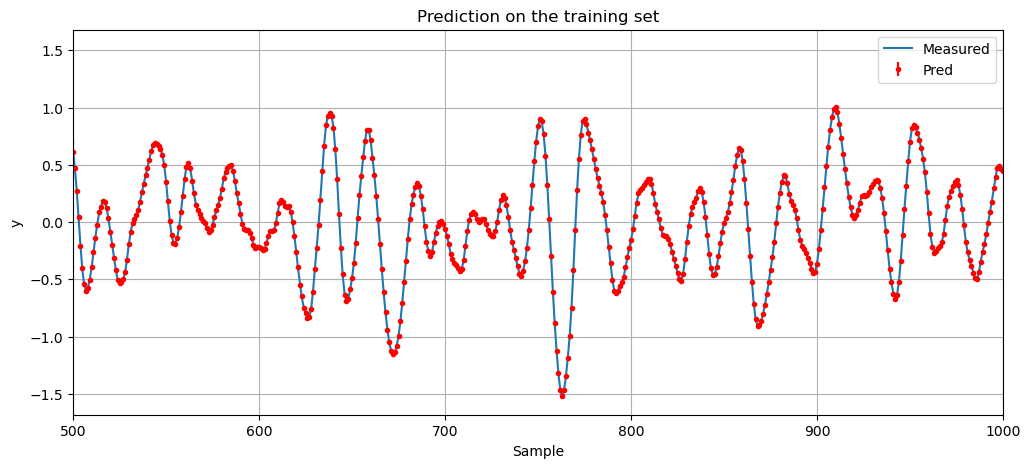

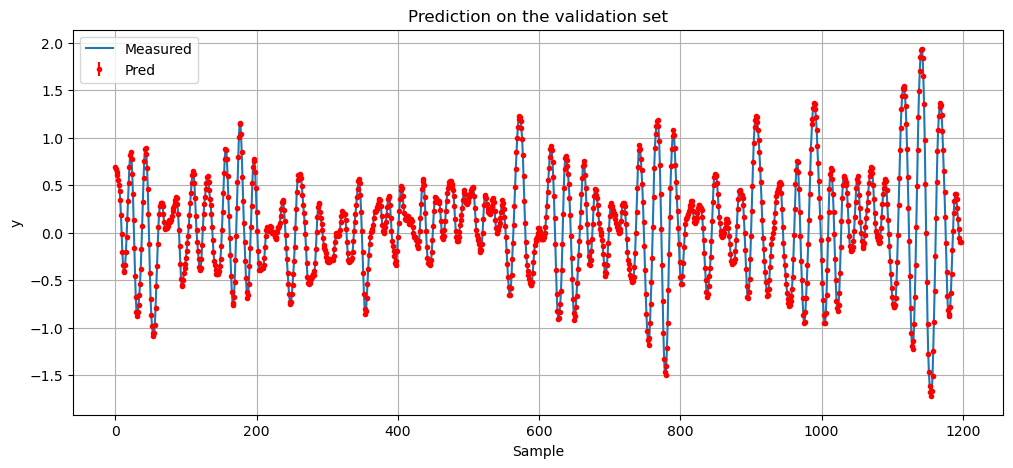

Validation NRMS = 0.009523375006689518


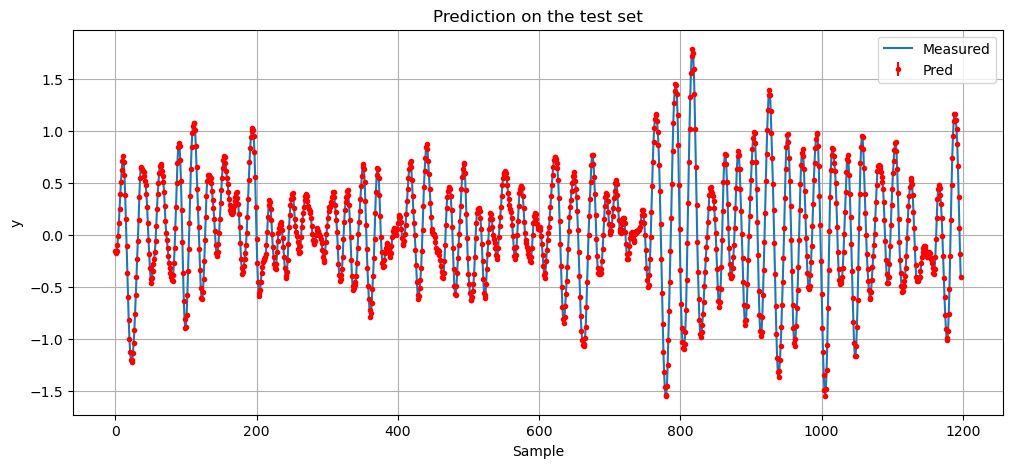

Test NRMS = 0.00803816674334085


In [20]:
# Plotting
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain, return_std=True) 
plt.figure(figsize=(12, 5)) 
plt.plot(Ytrain) 
plt.title('Prediction on the training set')
plt.errorbar(np.arange(len(Xtrain)), Ytrain_pred, yerr=2 * Ytrain_pred_std, fmt='.r') 
plt.grid()
plt.xlabel('Sample')
plt.ylabel('y')
plt.legend(['Measured', 'Pred'])
plt.xlim([500, 1000])
plt.show()

plt.figure(figsize=(12, 5)) 
plt.title('Prediction on the validation set')
plt.plot(Yval) 
Yval_pred, Yval_pred_std = reg.predict(Xval, return_std=True) 
plt.errorbar(np.arange(len(Xval)), Yval_pred, yerr=2 * Yval_pred_std, fmt='.r') 
plt.grid()
plt.xlabel('Sample')
plt.ylabel('y')
plt.legend(['Measured', 'Pred']) 
# plt.xlim([500, 1000])
plt.show()




print(f'Validation NRMS = {np.mean((Yval_pred - Yval) ** 2, axis=0) ** 0.5 / np.std(Yval)}')

plt.figure(figsize=(12, 5))
plt.title('Prediction on the test set')
plt.plot(Ytest)
ytest_pred, ytest_pred_std = reg.predict(Xtest, return_std=True)
plt.errorbar(np.arange(len(Xtest)), ytest_pred, yerr=2 * ytest_pred_std, fmt='.r')
plt.grid()
plt.xlabel('Sample')
plt.ylabel('y')
plt.legend(['Measured', 'Pred'])
# plt.xlim([500, 1000])
plt.show()

Ytest = Ytest.numpy()  # Convert Yval to a NumPy array

print(f'Test NRMS = {np.mean((ytest_pred - Ytest) ** 2, axis=0) ** 0.5 / np.std(Ytest)}')


